In [703]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import seaborn as sns
from scipy.ndimage import rotate, zoom
from matplotlib.patches import Rectangle
from skimage import measure
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.special import logit, expit
from tqdm import tqdm


In [704]:
# Get image numbers from train_images/authentic
authentic_path = "data/train_images/authentic"
authentic_files = glob.glob(os.path.join(authentic_path, "*.png"))
authentic_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in authentic_files]))

# Get image numbers from train_images/forged
forged_path = "data/train_images/forged"
forged_files = glob.glob(os.path.join(forged_path, "*.png"))
forged_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in forged_files]))

# Get image numbers from supplemental_images
supplemental_path = "data/supplemental_images"
supplemental_files = glob.glob(os.path.join(supplemental_path, "*.png"))
supplemental_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in supplemental_files]))

# Get train masks
train_masks_path = "data/train_masks"
train_masks = glob.glob(os.path.join(train_masks_path, "*.npy"))

# Get supplemental masks
supplemental_masks_path = "data/supplemental_masks"
supplemental_masks = glob.glob(os.path.join(supplemental_masks_path, "*.npy"))

print(f"Authentic images: {len(authentic_nums)}")
print(f"Forged images: {len(forged_nums)}")
print(f"Supplemental images: {len(supplemental_nums)}")

Authentic images: 2377
Forged images: 2751
Supplemental images: 48


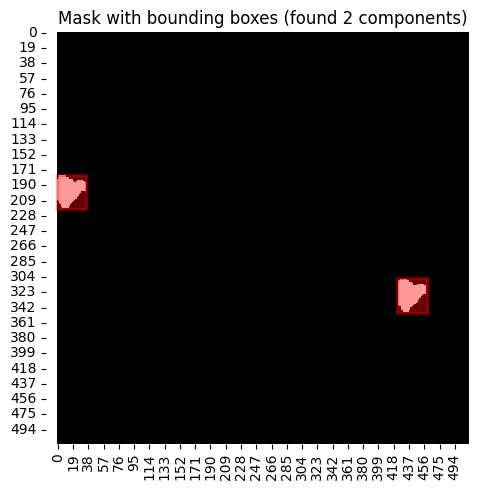

In [705]:
def resize_and_pad_mask(mask: np.ndarray, target=512):
    """
    Rotate so long side is horizontal, resize longest side to target,
    then pad shorter side to target. Uses nearest-neighbor interpolation.
    mask: H x W (or H x W x C label array)
    """
    h, w = mask.shape[:2]

    # Rotate if height > width
    if h > w:
        # rotate 90 degrees CCW; nearest interpolation
        mask = rotate(mask, 90, reshape=True, order=0)
        h, w = mask.shape[:2]

    # Scale long side
    scale = target / max(w, h)
    zoom_factors = (scale, scale) + ((1,) if mask.ndim == 3 else ())
    mask = zoom(mask, zoom_factors, order=0)

    new_h, new_w = mask.shape[:2]

    # Create padded 512x512 mask
    padded = np.zeros((target, target) + (() if mask.ndim == 2 else (mask.shape[2],)),
                      dtype=mask.dtype)

    pad_h = (target - new_h) // 2
    pad_w = (target - new_w) // 2

    padded[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = mask

    return padded

def get_bounding_boxes_with_margin(mask, margin=1):
    """
    Find the smallest bounding boxes that surround all connected components in a mask,
    with an added margin around each box.
    
    Args:
        mask: Binary mask array (2D numpy array with 1s and 0s)
        margin: Margin to add around each bounding box (default: 1)
    
    Returns:
        Array of bounding boxes, each as [min_row, min_col, max_row, max_col]
        Returns empty array if no components found
    """
    # Ensure mask is binary
    mask_bin = (mask > 0).astype(np.uint8)
    
    # Find connected components (islands of 1s)
    labeled_mask, num_features = ndimage.label(mask_bin)
    
    if num_features == 0:
        return np.array([]).reshape(0, 4)
    
    # Get bounding boxes for each component efficiently
    # find_objects returns a list of slice objects, one per component
    slices = ndimage.find_objects(labeled_mask)
    
    boxes = []
    H, W = mask_bin.shape
    
    for slice_obj in slices:
        if slice_obj is None:
            continue
            
        row_slice, col_slice = slice_obj
        
        # Get bounding box coordinates
        min_row = row_slice.start
        max_row = row_slice.stop - 1  # stop is exclusive, so subtract 1
        min_col = col_slice.start
        max_col = col_slice.stop - 1
        
        # Add margin, clamping to image boundaries
        min_row = max(0, min_row - margin)
        min_col = max(0, min_col - margin)
        max_row = min(H - 1, max_row + margin)
        max_col = min(W - 1, max_col + margin)
        
        # Calculate bounding box area
        width = max_col - min_col + 1
        height = max_row - min_row + 1
        area = width * height
        
        # Ignore tiny bounding boxes (less than 4 pixels)
        if area >= 25:
            boxes.append([min_row, min_col, max_row, max_col])
    
    return np.array(boxes)

# Plot bounding box over masks

mask_choice = np.random.choice(train_masks)
mask = resize_and_pad_mask(np.load(mask_choice)[0])

# Get bounding boxes
boxes = get_bounding_boxes_with_margin(mask)

# Plot mask
plt.figure(figsize=(5, 5))
sns.heatmap(mask, cmap='gray', cbar=False)

# Plot each bounding box with alpha=0.4

for box in boxes:
    min_row, min_col, max_row, max_col = box
    
    # Draw rectangle
    width = max_col - min_col + 1
    height = max_row - min_row + 1
    
    rect = Rectangle((min_col, min_row), width, height, 
                     linewidth=2, edgecolor='red', facecolor='red', alpha=0.4)
    plt.gca().add_patch(rect)

plt.title(f'Mask with bounding boxes (found {len(boxes)} components)')
plt.axis('equal')
plt.tight_layout()
plt.show()


## Compute Shape Properties

In [706]:
rows = []
property_list = ["area", "area_bbox", "eccentricity", "euler_number", 
                 "extent", "inertia_tensor", "inertia_tensor_eigvals", "moments_hu"]
additional_features = []

counter = 0
for mask_path in train_masks:
    mask = np.load(mask_path).squeeze()

    # Case 1: single 2D mask
    if mask.ndim == 2:
        channel_list = [mask]
        channel_names = [""]
    
    # Case 2: multi-channel mask of shape (C, H, W)
    elif mask.ndim == 3:
        C = mask.shape[0]
        channel_list = [mask[i].squeeze() for i in range(C)]
        channel_names = [f"_channel{i}" for i in range(C)]
    
    else:
        raise ValueError(f"Unexpected mask dimensions {mask.shape}. Expected 2D or (C,H,W).")

    # Process all channels independently
    for chan_mask, chan_name in zip(channel_list, channel_names):

        # Safety: each channel must be 2D
        if chan_mask.ndim != 2:
            raise ValueError(f"Channel not 2D after squeeze: {chan_mask.shape} from file {mask_path}")

        # Get total image pixels for normalization
        img_height, img_width = chan_mask.shape
        total_image_pixels = img_height * img_width

        # Get bounding boxes for each connected component
        boxes = get_bounding_boxes_with_margin(chan_mask, margin=1)
        
        # Process each bounding box separately
        for box_idx, box in enumerate(boxes):
            min_row, min_col, max_row, max_col = box
            
            # Extract the bounding box subset from the mask
            bbox_mask = chan_mask[min_row:max_row+1, min_col:max_col+1]
            
            # Label the cropped region
            labeled_bbox = measure.label(bbox_mask)
            
            # Compute features on just the bounding box subset
            props = measure.regionprops_table(labeled_bbox, properties=property_list)
            
            df_props = pd.DataFrame(props)
            
            # Normalize area and area_bbox as fractions of total image pixels
            df_props["area"] = df_props["area"] / total_image_pixels
            df_props["area_bbox"] = df_props["area_bbox"] / total_image_pixels
            
            if "prop_bbox" in additional_features:
                df_props["prop_bbox"] = (df_props["area"] / df_props["area_bbox"])
            
            # include the mask filename + channel suffix + box index
            base = os.path.basename(mask_path)
            df_props["mask_name"] = base + chan_name + f"_bbox{box_idx}"
            
            rows.append(df_props)
        
    if counter % 100 == 0:
        print("processed mask ", counter)
    
    counter += 1

# concatenate into single df
regionprops_df = pd.concat(rows, ignore_index=True)

regionprops_df

processed mask  0
processed mask  100
processed mask  200
processed mask  300
processed mask  400
processed mask  500
processed mask  600
processed mask  700
processed mask  800
processed mask  900
processed mask  1000
processed mask  1100
processed mask  1200
processed mask  1300
processed mask  1400
processed mask  1500
processed mask  1600
processed mask  1700
processed mask  1800
processed mask  1900
processed mask  2000
processed mask  2100
processed mask  2200
processed mask  2300
processed mask  2400
processed mask  2500
processed mask  2600
processed mask  2700


,area,area_bbox,eccentricity,euler_number,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,mask_name
0,0.003815,0.005493,0.464544,1,0.694444,19.371904,-2.186944,-2.186944,21.736384,23.040188,18.068100,0.164433,0.000396,0.000241,0.000002,1.882607e-11,3.256341e-08,4.131215e-11,48280.npy_bbox0
1,0.004181,0.005493,0.475075,1,0.761111,19.684799,0.122756,0.122756,25.416551,25.419179,19.682172,0.164603,0.000438,0.000244,0.000002,3.088980e-11,4.291634e-08,4.903545e-11,48280.npy_bbox1
2,0.003418,0.005188,0.470554,1,0.658824,20.294324,1.456075,1.456075,16.722716,20.812701,16.204339,0.165255,0.000423,0.000255,0.000003,4.585435e-11,5.115044e-08,5.398402e-11,48280.npy_bbox2
3,0.039321,0.046730,0.830833,1,0.841463,1183.209239,-151.992653,-151.992653,3782.852083,3791.708428,1174.352895,0.189631,0.009989,0.000056,0.000003,3.899565e-11,2.903234e-07,1.512884e-11,8081.npy_bbox0
4,0.035838,0.043477,0.835328,1,0.824285,1066.933540,-142.648178,-142.648178,3494.231684,3502.586120,1058.579104,0.191100,0.010485,0.000066,0.000004,5.463008e-11,3.555251e-07,1.976421e-11,8081.npy_bbox1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8782,0.001114,0.001511,0.775986,1,0.737374,5.710640,-2.680240,-2.680240,7.212235,9.244850,3.678025,0.177026,0.005815,0.000031,0.000003,3.206492e-11,2.563307e-07,1.671775e-11,36035.npy_bbox2
8783,0.002265,0.005967,0.966538,1,0.379506,1828.254770,49.663832,49.663832,121.846749,1829.698979,120.402539,0.448505,0.154545,0.055803,0.044269,2.200131e-03,1.715064e-02,-2.235900e-05,64773.npy_bbox0
8784,0.002293,0.008456,0.966648,-2,0.271204,299.397069,-525.891287,-525.891287,1678.621483,1856.261628,121.756924,0.449243,0.155186,0.055666,0.044194,2.191865e-03,1.715651e-02,-2.178004e-05,64773.npy_bbox1
8785,0.010222,0.010222,0.930630,1,1.000000,420.000000,-0.000000,-0.000000,56.250000,420.000000,56.250000,0.257990,0.038828,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,32535.npy_bbox0


In [707]:
regionprops_df.to_csv("regionprops_df.csv")

In [708]:
# Logit Transform these columns
regionprops_df_describe = regionprops_df.describe().T[["min","max"]]
regionprops_df_describe = regionprops_df_describe[(regionprops_df_describe["max"] <= 1) & (regionprops_df_describe["min"] >= 0)]
regionprops_df_describe

,min,max
area,5.208333e-07,0.468490
area_bbox,5.208333e-07,0.586267
eccentricity,0.000000e+00,1.000000
extent,1.524548e-01,1.000000


In [779]:
df_std = regionprops_df.copy()

logit_cols = ["eccentricity", "extent", "area", "area_bbox"]
df_std[logit_cols] = df_std[logit_cols].clip(lower=1e-12, upper=1-1e-12)
df_std[logit_cols] = logit(df_std[logit_cols])

numeric_cols = df_std.select_dtypes(include="number").columns

# standardize
scaler = StandardScaler()
df_std[numeric_cols] = scaler.fit_transform(df_std[numeric_cols])

df_std.head()

,area,area_bbox,eccentricity,euler_number,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,mask_name
0,-0.126575,-0.110366,-0.531333,0.1412,-0.403058,-0.186904,-0.005202,-0.005202,-0.208558,-0.253084,-0.370629,-0.555975,-0.140121,-0.054077,-0.032593,-0.013425,-0.017128,0.010109,48280.npy_bbox0
1,-0.076320,-0.110366,-0.515639,0.1412,-0.365838,-0.186872,-0.003026,-0.003026,-0.208192,-0.252912,-0.369158,-0.554220,-0.139910,-0.053922,-0.032575,-0.013425,-0.017128,0.010109,48280.npy_bbox1
2,-0.186757,-0.142821,-0.522372,0.1412,-0.421009,-0.186809,-0.001769,-0.001769,-0.209057,-0.253246,-0.372327,-0.547507,-0.139985,-0.053378,-0.032559,-0.013425,-0.017128,0.010110,48280.npy_bbox2
3,1.167128,1.122684,0.112152,0.1412,-0.309604,-0.066011,-0.146389,-0.146389,0.165662,0.020310,0.682991,-0.296223,-0.092740,-0.063179,-0.032536,-0.013425,-0.017121,0.010108,8081.npy_bbox0
4,1.114498,1.080018,0.124149,0.1412,-0.323211,-0.078089,-0.137582,-0.137582,0.136945,-0.000664,0.577496,-0.281086,-0.090290,-0.062693,-0.032507,-0.013425,-0.017119,0.010108,8081.npy_bbox1


In [780]:
df_std.to_csv("regionprops_df_norm.csv")

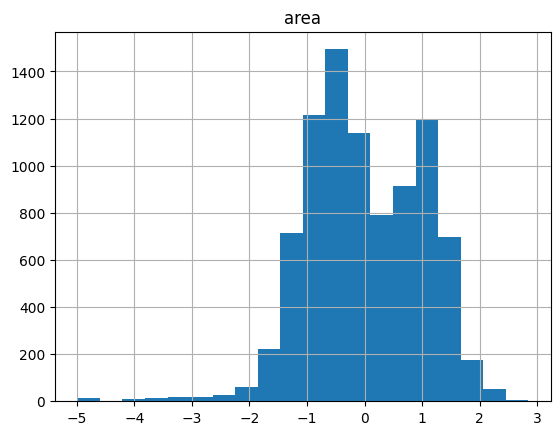

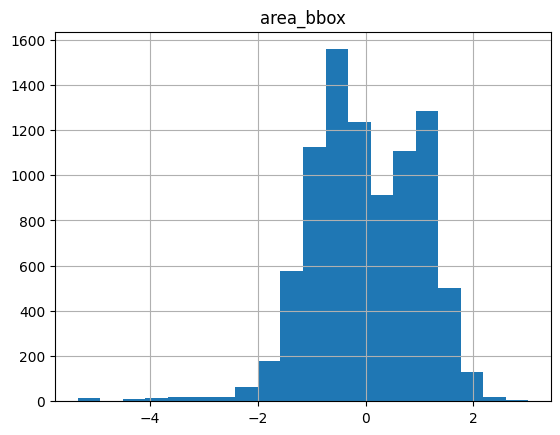

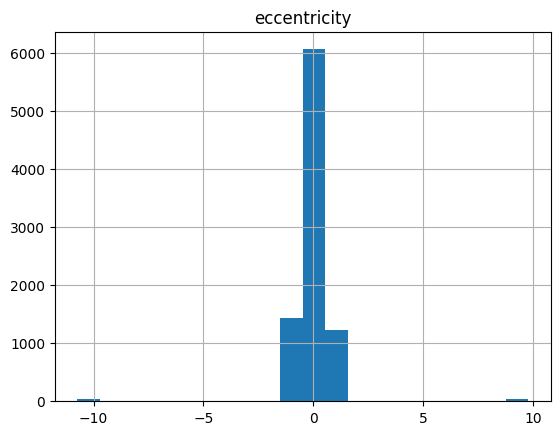

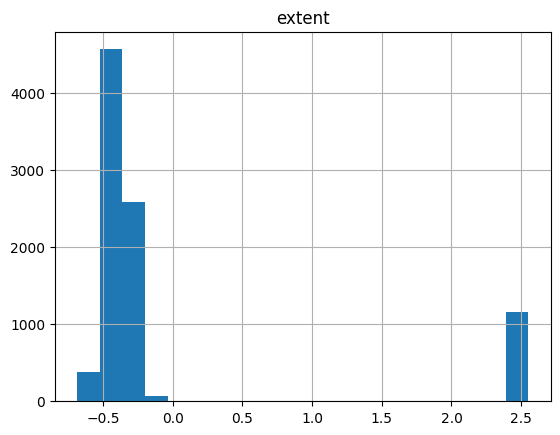

In [796]:
# Using gaussian like features only
feature_cols = ["area", "area_bbox", "eccentricity", "extent"]
for f in feature_cols:
    df_std[f].hist(bins=20)
    plt.title(f)
    plt.show()


<Axes: >

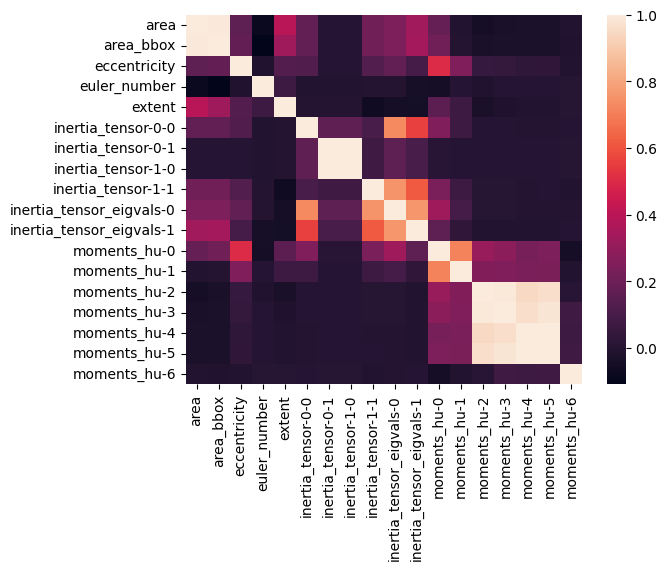

In [782]:
sns.heatmap(df_std.corr(numeric_only=True))

<Axes: >

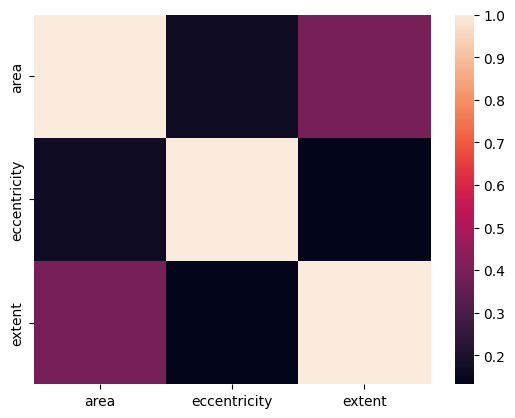

In [795]:
sns.heatmap(df_std[["area", "eccentricity", "extent"]].corr(numeric_only=True))

## GMM

In [887]:

cluster_df = df_std.copy()

# -------------------------
# Select numerical columns
# -------------------------
# Only select uncorrelated, gaussian features
feature_cols = ["area", "eccentricity", "extent"]

# feature_cols = cluster_df.select_dtypes(include="number").columns

# Excluding area (scale invariant)
# feature_cols = cluster_df.select_dtypes(include="number").columns.drop(["area", "area_bbox"])

# For fully invariant clustering
# feature_cols = [
#     "eccentricity", "euler_number",
#     "moments_hu-0","moments_hu-1","moments_hu-2",
#     "moments_hu-3","moments_hu-4","moments_hu-5","moments_hu-6"
# ]

X = cluster_df[feature_cols].values

# -------------------------
# Scan k and compute BIC + ICL
# -------------------------
candidate_ks = range(2,8)  # adjust as needed

bic_scores = []
icl_scores = []
gmm_models = []

for k in tqdm(candidate_ks):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(X)

    # BIC on full data
    bic = gmm.bic(X)

    # Responsibilities (posterior cluster probs)
    resp = gmm.predict_proba(X)  # shape (n_samples, k)

    # Classification entropy term: -∑_i ∑_k τ_ik log τ_ik
    # (add small epsilon to avoid log(0))
    eps = 1e-12
    entropy = -np.sum(resp * np.log(resp + eps))

    # ICL = BIC + 2 * entropy
    icl = bic + 2.0 * entropy

    bic_scores.append(bic)
    icl_scores.append(icl)
    gmm_models.append(gmm)

print("BIC by k:", dict(zip(candidate_ks, bic_scores)))
print("ICL by k:", dict(zip(candidate_ks, icl_scores)))

# -------------------------
# Pick best k by ICL (min ICL)
# -------------------------
best_idx = int(np.argmin(icl_scores))
best_k = candidate_ks[best_idx]
best_gmm = gmm_models[best_idx]

print(f"Selected n_components by ICL: {best_k}")

# -------------------------
# Final clustering with best GMM
# -------------------------
clusters = best_gmm.predict(X)
probs = best_gmm.predict_proba(X)

cluster_df["gmm_cluster"] = clusters

for k in range(best_k):
    cluster_df[f"gmm_prob_{k}"] = probs[:, k]


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]

BIC by k: {2: np.float64(16612.425747426343), 3: np.float64(10380.084888472578), 4: np.float64(7066.537020887335), 5: np.float64(7671.821307938917), 6: np.float64(4232.929808734892), 7: np.float64(1960.5729573672638)}
ICL by k: {2: np.float64(16612.425747408768), 3: np.float64(10491.130609801065), 4: np.float64(7632.22382212565), 5: np.float64(14837.036714885402), 6: np.float64(11397.15260576033), 7: np.float64(8956.755556664766)}
Selected n_components by ICL: 4


In [888]:
cluster_df[feature_cols].head()

,area,eccentricity,extent
0,-0.126575,-0.531333,-0.403058
1,-0.076320,-0.515639,-0.365838
2,-0.186757,-0.522372,-0.421009
3,1.167128,0.112152,-0.309604
4,1.114498,0.124149,-0.323211


In [889]:
cluster_df["gmm_cluster"].value_counts()

gmm_cluster
3    6466
1    1140
0    1083
2      98
Name: count, dtype: int64

## Cluster Separability

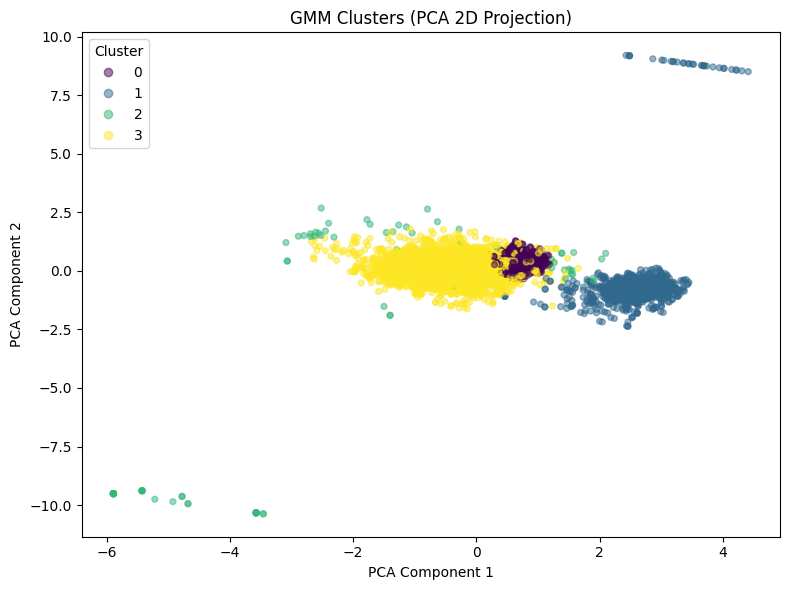

In [890]:

# Select numeric columns except the cluster label

X = cluster_df[feature_cols].values
y = cluster_df["gmm_cluster"].values

# ---- PCA to 2D ----
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)

# ---- Plot ----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=y, 
    s=18, 
    alpha=0.5
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clusters (PCA 2D Projection)")

# Legend with cluster labels
plt.legend(*scatter.legend_elements(), title="Cluster")

plt.tight_layout()
plt.show()


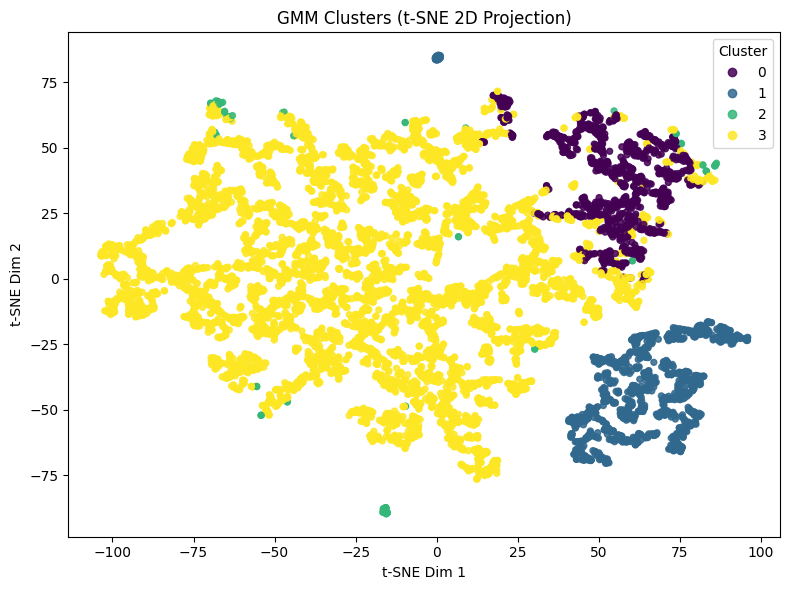

In [891]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Features for t-SNE (exclude cluster label)

X = cluster_df[feature_cols].values
y = cluster_df["gmm_cluster"].values

# ----- Fit t-SNE -----
tsne = TSNE(
    n_components=2,
    perplexity=30,      # typical values: 5–50
    learning_rate=200,  # default 200
    random_state=0
)

X_tsne = tsne.fit_transform(X)

# ----- Plot -----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    s=18,
    alpha=0.85
)

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("GMM Clusters (t-SNE 2D Projection)")

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

Fraction of masks with GMM probability of maximum cluster > 0.9: 0.9650620234437237


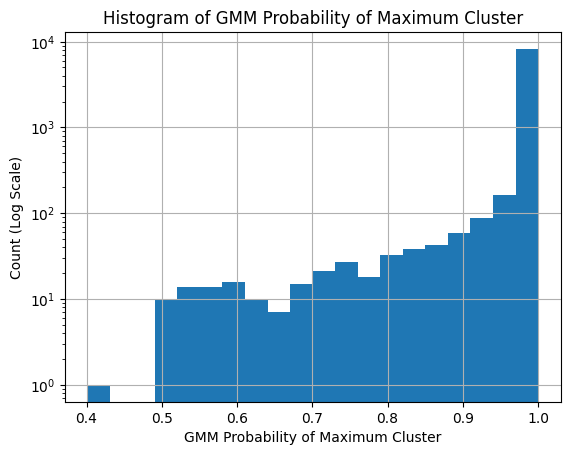

In [901]:
gmm_prob_cols = [c for c in cluster_df.columns if "gmm_prob" in c]
cluster_df["gmm_prob_max"] = cluster_df[gmm_prob_cols].max(axis=1)
cluster_df["gmm_prob_max"].hist(bins=20,  log = True)
plt.title("Histogram of GMM Probability of Maximum Cluster")
plt.xlabel("GMM Probability of Maximum Cluster")
plt.ylabel("Count (Log Scale)")

print("Fraction of masks with GMM probability of maximum cluster > 0.9:", (cluster_df["gmm_prob_max"] > 0.9).mean())

## Cluster Explainability

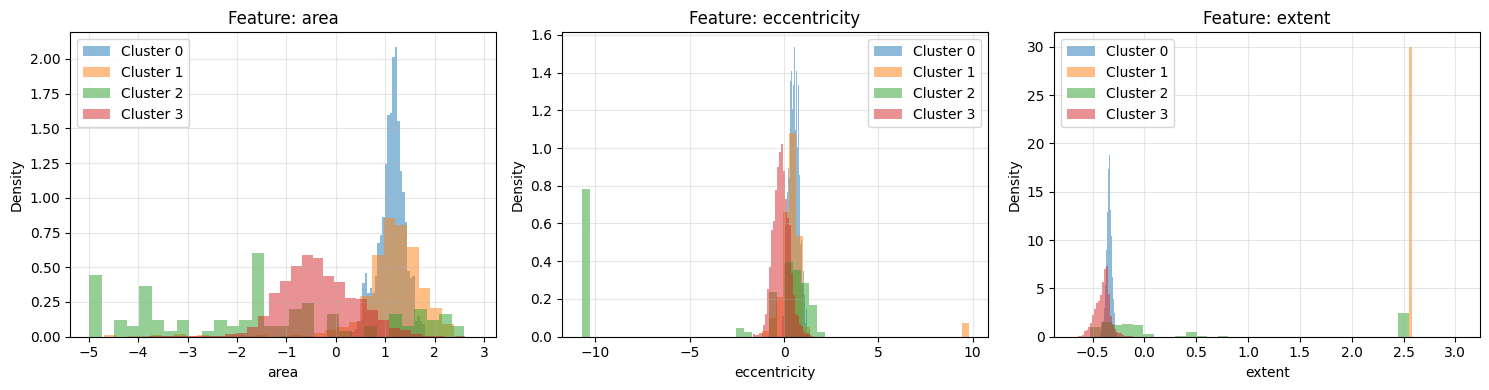

In [905]:
clusters = cluster_df["gmm_cluster"].unique()
clusters = np.sort(clusters)

# Plot features in 1x3 grids (3 features per grid)
n_features = len(feature_cols)
n_grids = int(np.ceil(n_features / 3))

for grid_idx in range(n_grids):
    # Create 1x3 grid for this batch
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Get features for this grid (up to 3)
    start_idx = grid_idx * 3
    end_idx = min(start_idx + 3, n_features)
    features_in_grid = feature_cols[start_idx:end_idx]
    
    for subplot_idx, col in enumerate(features_in_grid):
        ax = axes[subplot_idx]
        
        for k in clusters:
            data = cluster_df.loc[cluster_df["gmm_cluster"] == k, col]
            ax.hist(
                data,
                bins=30,
                alpha=0.5,
                label=f"Cluster {k}",
                density=True  # optional, makes curves comparable
            )
        
        ax.set_title(f"Feature: {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for subplot_idx in range(len(features_in_grid), 3):
        axes[subplot_idx].axis('off')
    
    plt.tight_layout()
    plt.show()


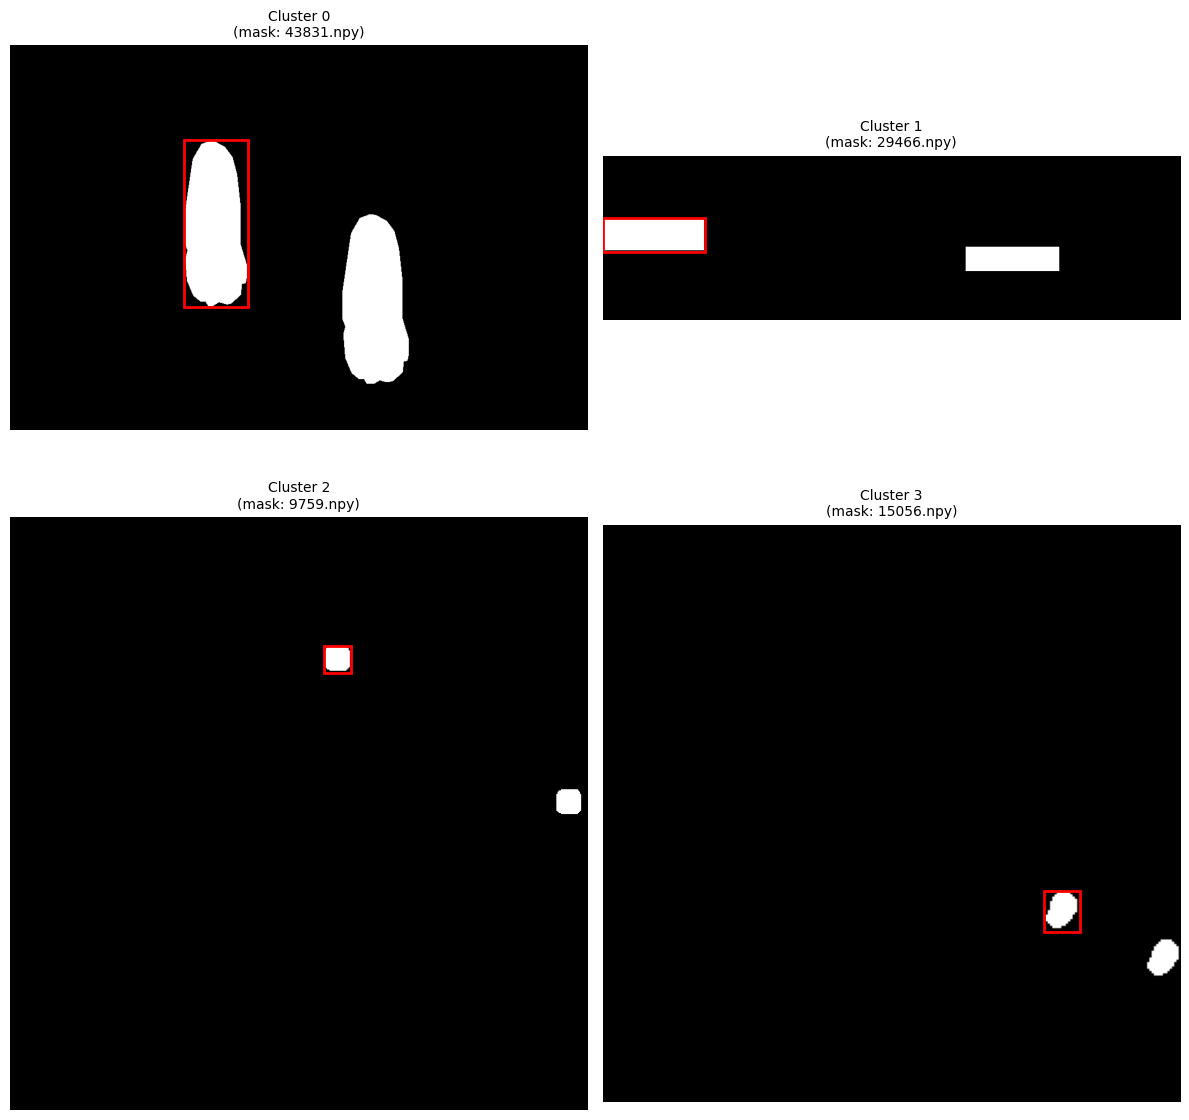

In [902]:
import re
from scipy.spatial.distance import cdist

# Get the feature matrix and centroids
X = cluster_df[feature_cols].values
centroids = best_gmm.means_

# Create 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for c in range(best_k):
    c_df = cluster_df[cluster_df["gmm_cluster"] == c]
    
    if len(c_df) == 0:
        axes[c].axis('off')
        continue
    
    # Get indices of points in this cluster
    cluster_indices = c_df.index.values
    X_cluster = X[cluster_indices]
    
    # Find the point closest to the centroid
    centroid = centroids[c].reshape(1, -1)  # Reshape for cdist
    distances = cdist(X_cluster, centroid).flatten()
    closest_idx = cluster_indices[np.argmin(distances)]
    
    # Get the mask name for the closest point
    mask_name_with_suffix = cluster_df.loc[closest_idx, "mask_name"]
    
    # Extract channel ID if present
    channel_match = re.search(r'_channel(\d+)', mask_name_with_suffix)
    channel_id = int(channel_match.group(1)) if channel_match else None
    
    # Extract bbox index
    bbox_match = re.search(r'_bbox(\d+)', mask_name_with_suffix)
    bbox_idx = int(bbox_match.group(1)) if bbox_match else None
    
    # Extract base filename by removing _channel\d+ and _bbox\d+ suffixes
    base_mask_name = re.sub(r'_channel\d+', '', mask_name_with_suffix)
    base_mask_name = re.sub(r'_bbox\d+$', '', base_mask_name)
    
    # Load the mask file
    c_sample = train_masks_path + "/" + base_mask_name
    c_masks = np.load(c_sample).squeeze()
    
    # Extract specific channel if channel_id is specified, otherwise use the whole mask
    if channel_id is not None and c_masks.ndim == 3:
        chan_mask = c_masks[channel_id]
    elif c_masks.ndim == 3:
        # If multi-channel but no channel specified, use first channel
        chan_mask = c_masks[0]
    else:
        chan_mask = c_masks
    
    # Get bounding boxes for this channel
    boxes = get_bounding_boxes_with_margin(chan_mask, margin=1)
    
    # Get the specific bounding box if bbox_idx is specified
    bbox = None
    if bbox_idx is not None and bbox_idx < len(boxes):
        bbox = boxes[bbox_idx]
    
    # Plot in the grid
    ax = axes[c]
    ax.imshow(chan_mask, cmap='gray')
    
    # Draw bounding box if available
    if bbox is not None:
        min_row, min_col, max_row, max_col = bbox
        width = max_col - min_col + 1
        height = max_row - min_row + 1
        rect = Rectangle((min_col, min_row), width, height, 
                        linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    ax.set_title(f"Cluster {c}\n(mask: {base_mask_name})", fontsize=10)
    ax.axis('off')

# Hide unused subplots if there are fewer than 4 clusters
for c in range(best_k, 4):
    axes[c].axis('off')

plt.tight_layout()
plt.show()

## Gaussian assumption


Cluster 0: KS p-value vs χ²(3) = 2.25e-13

Cluster 1: KS p-value vs χ²(3) = 6.3e-287

Cluster 2: KS p-value vs χ²(3) = 0.00987

Cluster 3: KS p-value vs χ²(3) = 6.18e-25


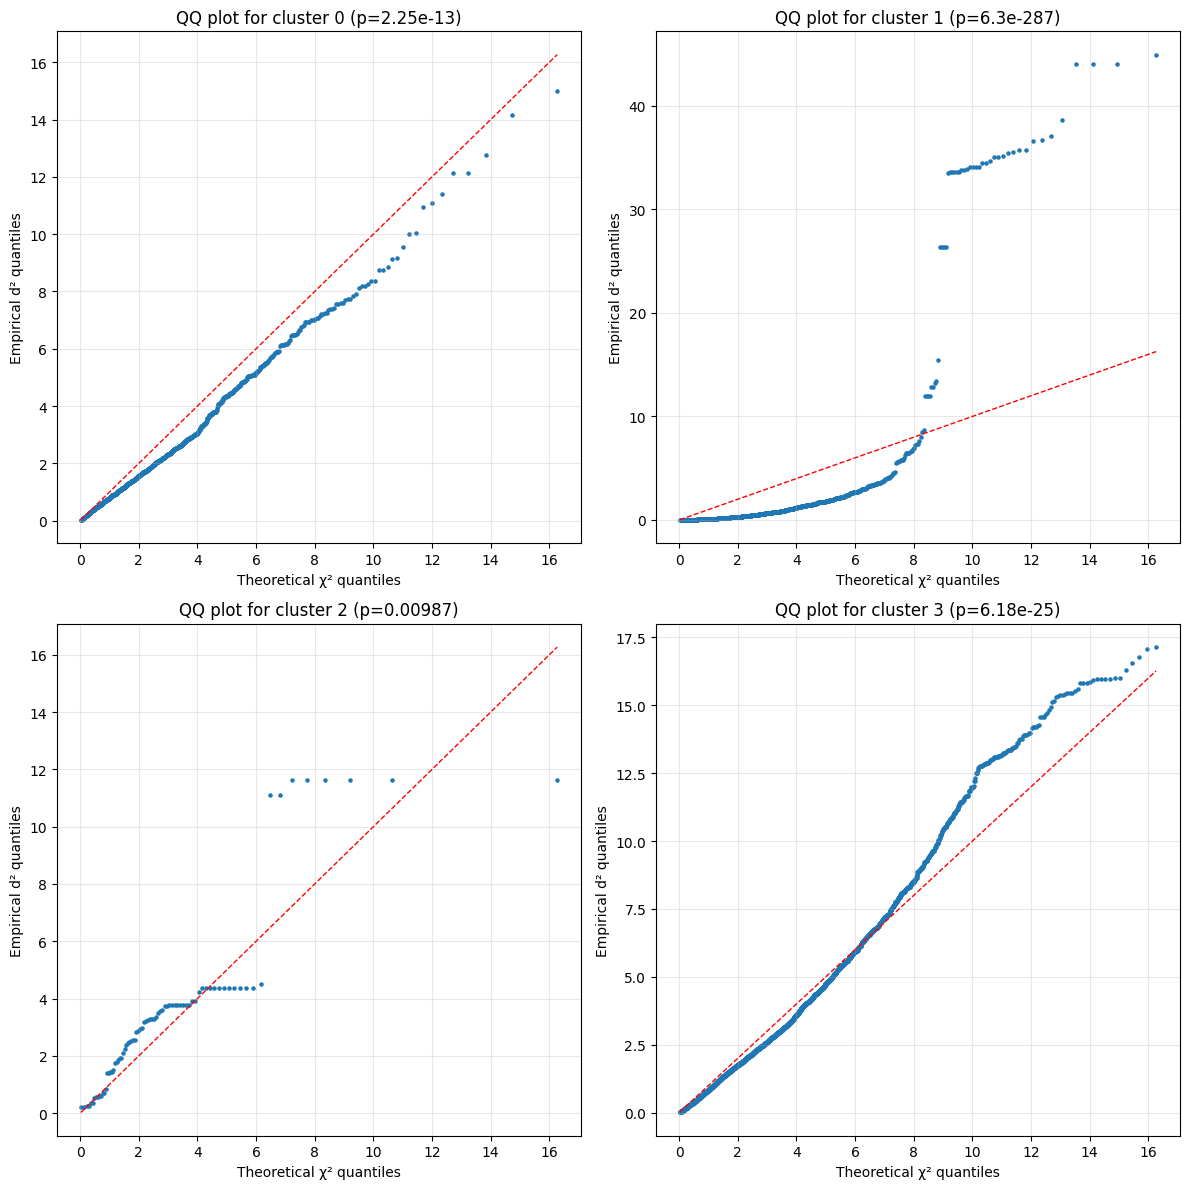

In [903]:
import numpy as np
import pandas as pd
from scipy.stats import chi2, kstest
import matplotlib.pyplot as plt

X = cluster_df[cluster_df["gmm_prob_max"] > 0.9][feature_cols].values
labels = cluster_df[cluster_df["gmm_prob_max"] > 0.9]["gmm_cluster"].values

n_components, d = best_gmm.means_.shape

# Create 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for k in range(n_components):
    Xk = X[labels == k]
    mu = best_gmm.means_[k]
    Sigma = best_gmm.covariances_[k]  # adjust if using tied/diag/spherical

    # Mahalanobis squared distances
    Sigma_inv = np.linalg.inv(Sigma)
    diffs = Xk - mu
    d2 = np.einsum("ni,ij,nj->n", diffs, Sigma_inv, diffs)

    # KS test against chi-square(d)
    stat, pval = kstest(d2, chi2(df=d).cdf)
    print(f"\nCluster {k}: KS p-value vs χ²({d}) = {pval:.3g}")

    # QQ plot
    sorted_d2 = np.sort(d2)
    q = chi2.ppf(np.linspace(0.001, 0.999, len(sorted_d2)), df=d)

    # Plot in the grid
    ax = axes[k]
    ax.scatter(q, sorted_d2, s=5)
    ax.plot(q, q, 'r--', linewidth=1)  # ideal line
    ax.set_xlabel("Theoretical χ² quantiles")
    ax.set_ylabel("Empirical d² quantiles")
    ax.set_title(f"QQ plot for cluster {k} (p={pval:.3g})")
    ax.grid(alpha=0.3)

# Hide unused subplots if there are fewer than 4 clusters
for k in range(n_components, 4):
    axes[k].axis('off')

plt.tight_layout()
plt.show()
